# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Импорт библитек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re as re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
from catboost import Pool, cv

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [2]:
data = pd.read_csv("/workspaces/Data-Science/Customer_churn/dataset/Churn_Modelling.csv")
data.head(10)
#Исходные данные взятые из Kagle

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


В исходных данных отсутствуют пропусщенные значения

### Изучениие данных Churn_Modelling.csv

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата
* Целевой признак
* Exited — факт ухода клиента

In [5]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]#Приведем название столбцов к змеиному регистру
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [6]:
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']#Приведем название столбцов к змеиному регистру
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Рассмотрим наличие редких и выбивающихся значений проанализировав через метод .describe()

In [8]:
data.describe(include='all')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


* Отсутствуют аномалии

In [9]:
data.groupby('exited')['customer_id'].count()# рассмотрим целевой признак. Каждый четвертый покидает банк

exited
0    7963
1    2037
Name: customer_id, dtype: int64

In [10]:
data[data['balance']==0].groupby('exited')['customer_id'].count()# Каждый шестой клиент с нулевым балансом покидает банк

exited
0    3117
1     500
Name: customer_id, dtype: int64

### Проверим дубликаты

In [11]:
data.duplicated().sum()

0

### Удалим неинформативные столбцы, не нужные для модели row_number, customer_id, surname

In [12]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1).copy()
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


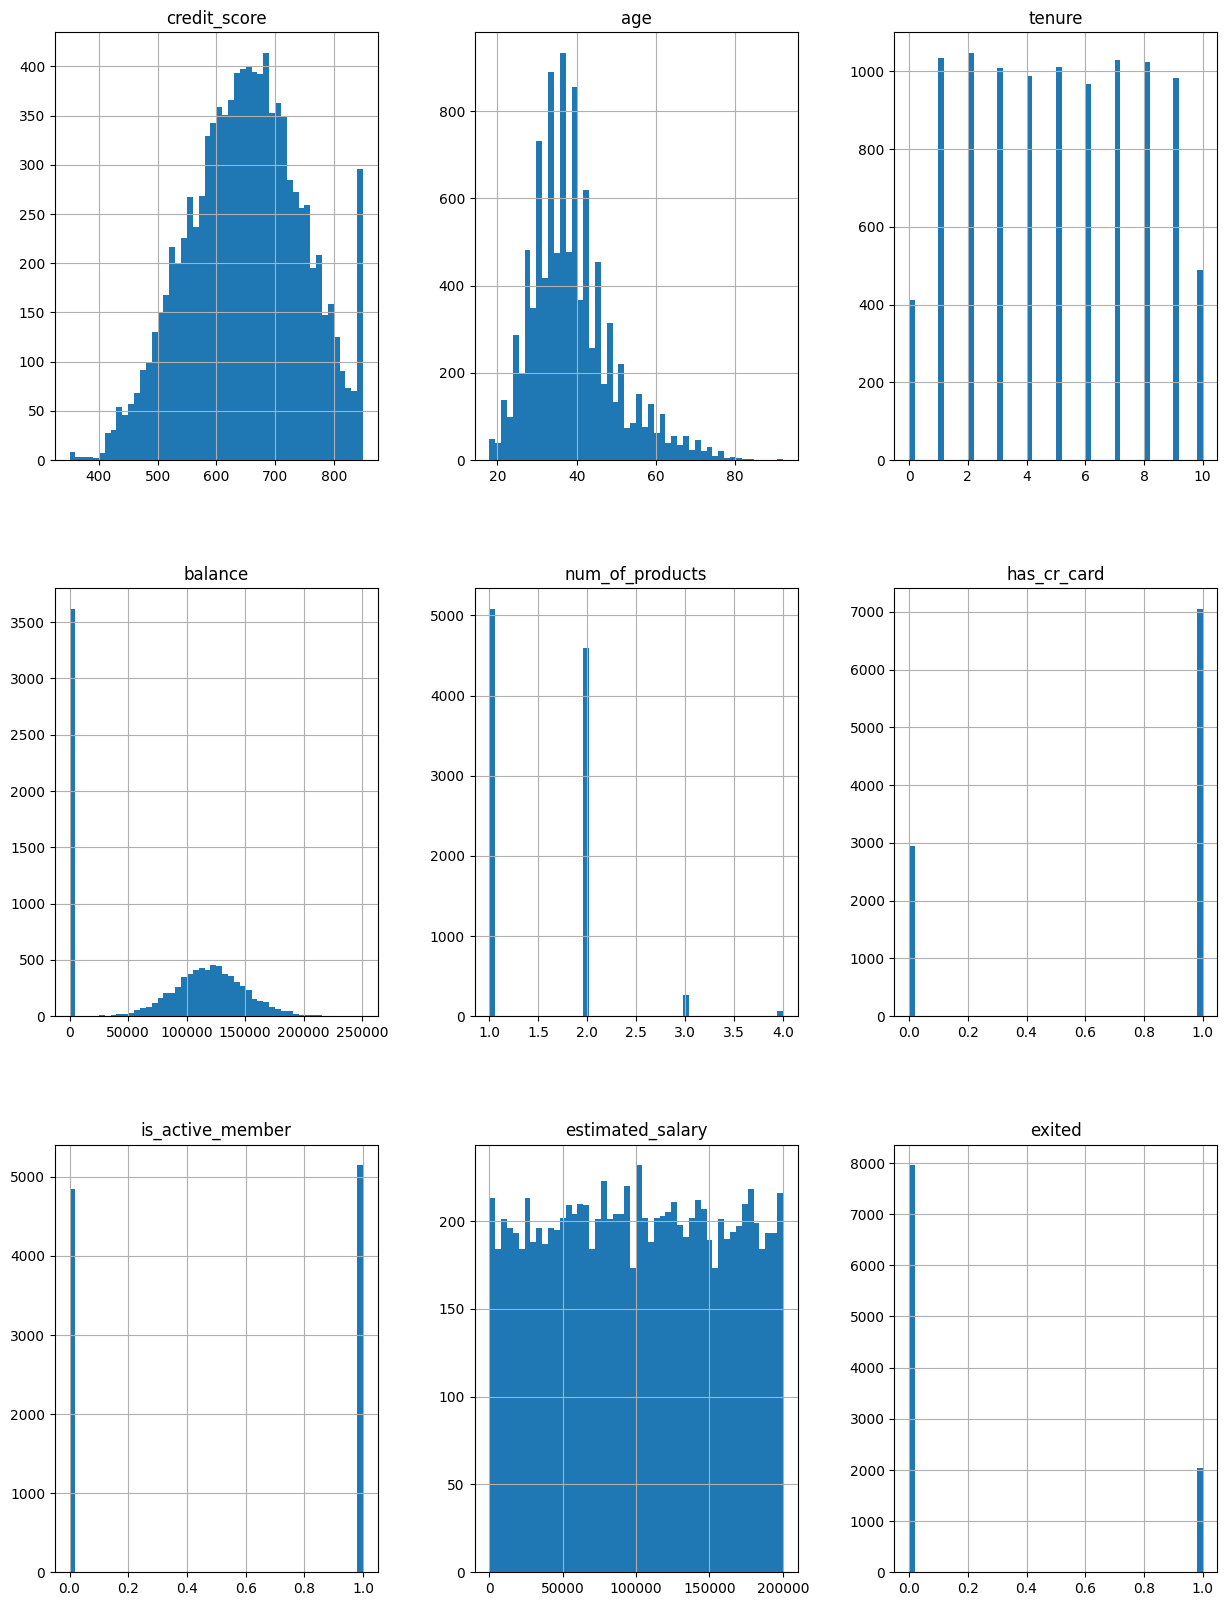

In [13]:
data.hist(bins=50, figsize=(15, 20))#построили общую гистограмму для всех числовых столбцов
plt.show()


### Выводы

1. Из 10000 клиентов покинуло банк 2037 клиентов. 
2. Название колонок приведены к змеинному и нижнему регистру
3. Анамалии не были выявленны
4. Наблюдается дисбаланс классов. Количество уходов клиентов, примерно, в четыре раза меньше оставшихся
5. Люди с нулевым балансом чаще покидают банк

## Исследование задачи

Из банка стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
1. Построим модель с предельно большим значением F1-меры. Проверим F1-меру на тестовой выборке.
2. Дополнительно измерим AUC-ROC, сравнивайте её значение с F1-мерой.
3. У нас наблюдается дисбаланс классов, правильность (accuracy) нам не подходит.
Для решения данной задачи предлагаю использовать алгоритмы Логистической регрессии, Случайного леса и Древа решений, Catboost

### One-hot Encoding

In [14]:
def unique_values(data):
    for column in data : 
        if data[column].dtypes == 'object':
            print(f'{column}:{data[column].unique()}:{len(data[column].unique())}')
unique_values(data)

geography:['France' 'Spain' 'Germany']:3
gender:['Female' 'Male']:2


Преобразовать категориальные признаки в численные поможет техника прямого кодирования , или отображения One-Hot Encoding.
Техникой OHE категориальные признаки переводятся в численные в два этапа:
1. Для каждого значения признака создаётся новый столбец;
2. Если объекту категория подходит, присваивается 1, если нет — 0.
Новые признаки называются дамми-переменными , или дамми-признаками.
Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies().
Преобразуем категорийые признаки колонок gender и geography  One-hot Encoding методом в численные.

In [15]:
data.groupby('gender')['estimated_salary'].count()# рассмотрим целевой признак

gender
Female    4543
Male      5457
Name: estimated_salary, dtype: int64

In [16]:
data.groupby('geography')['estimated_salary'].count()# рассмотрим целевой признак

geography
France     5014
Germany    2509
Spain      2477
Name: estimated_salary, dtype: int64

In [17]:
data['gender'] = pd.get_dummies(data["gender"], drop_first=True)

In [18]:
pd.get_dummies(data["geography"], drop_first=True)

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,1,0


In [19]:
data_ohe = pd.get_dummies(data["geography"], drop_first=True)

In [20]:
data = pd.concat([data, data_ohe], axis=1)#добавим новые столбцы из geography

data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,0,1


In [21]:
data = data.drop(['geography'], axis=1).copy()#удалим столбец geography
data.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


 ### Разобьем данные на выборки

In [22]:
# отделим 20% данных для тестовой выборки выборки (для проверки модели)

In [23]:
target = data['exited']
features = data.drop(['exited'] , axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [24]:
# отделим 25% данных(от other) для разделения на обучающую и валидационную выборку

In [25]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.25, random_state=12345)

In [26]:
print('Размер обучающей выборки', len(features_train))
print('Размер валидационной выборки', len(features_valid))
print('Размер тестовой выборки', len(features_test))

Размер обучающей выборки 6000
Размер валидационной выборки 2000
Размер тестовой выборки 2000


### Масштабирование признаков

Если в данных присутствуют колличественные признаки с разными разбросами значений, то алгорим может решить, что признаки с большими значениями и разбросом важнее. Чтобы избежать этой
ловушки, признаки масштабируются — приводятся к одному масштабу.

In [27]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
492,-0.134048,0,-0.078068,-0.357205,0.076163,0.816929,0,1,0.331571,0,0
6655,-1.010798,1,0.494555,0.676673,0.136391,-0.896909,1,1,-0.727858,0,0
4287,0.639554,1,1.353490,-1.391083,0.358435,-0.896909,1,1,-0.477006,1,0
42,-0.990168,0,2.116987,-1.046457,0.651725,-0.896909,1,1,-0.100232,0,0
8178,0.567351,0,0.685430,0.676673,0.813110,0.816929,1,1,0.801922,0,0


In [28]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
2358,0.175393,1,0.399118,-1.391083,1.385698,-0.896909,0,1,-1.466761,0,0
8463,-1.299609,1,0.971741,-1.046457,-1.232442,-0.896909,1,0,0.254415,0,1
163,0.711757,0,-0.268942,-1.046457,-1.232442,0.816929,1,1,0.122863,0,1
3074,-0.391916,0,0.494555,0.332047,0.672529,-0.896909,1,0,0.585847,1,0
5989,0.165078,0,1.353490,1.710552,0.536522,-0.896909,0,0,1.462457,0,0


In [29]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,Germany,Spain
7867,-0.123733,0,0.685430,-0.701831,-1.232442,-0.896909,1,1,0.980212,0,1
1402,1.083087,1,-0.937002,1.021300,0.858518,-0.896909,1,0,-0.390486,0,0
8606,1.598822,1,0.303681,-0.012579,-1.232442,0.816929,1,1,-0.435169,0,1
8885,0.165078,1,0.589993,-0.357205,0.412100,0.816929,1,1,1.017079,0,1
6494,0.484834,1,-1.032439,0.676673,-1.232442,0.816929,1,1,-1.343558,0,0


### Исследование моделей без учета дисбаланса

In [30]:
#для удобства вывода в дальнейшем - соберем показатели в списки

tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []

####  Модель Логистическая регрессия

In [31]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))# посчитаем качество модели на валидационной выборке

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1: 0.30393996247654786
AUC_ROC = 0.770



In [32]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('without_imbalance')


Малое значение F1. Подбирать параметры и разбирать с дисбалансом будем позже

#### Модель Дерево решений 

In [33]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) # обучим модель с заданной глубиной дерева
	model.fit(features_train, target_train) # обучим модель
	predicted_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
	result = f1_score(target_valid, predicted_valid) # посчитаем качество модели
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1 лучшей модели: 0.5520504731861199
max_depth лучшей модели: DecisionTreeClassifier(max_depth=7)
AUC_ROC = 0.824

CPU times: user 301 ms, sys: 0 ns, total: 301 ms
Wall time: 305 ms


In [34]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('without_imbalance')



Намного лучше, но рассмотрим остальные модели

#### Модель случайный лес

In [35]:
%%time
1 + 1

best_result = 0
for est in range(10, 101, 10):     
    for depth in range(1, 30):
        for samples_split in range(2, 51, 10):
            model = RandomForestClassifier(max_depth=depth, min_samples_split=samples_split, n_estimators=est, random_state=12345)
            model.fit(features_train, target_train) # обучим модель
            predicted_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
            result = f1_score(target_valid, predicted_valid) # посчитаем качество модели
            if result > best_result:
                best_model = model
                best_result = result

CPU times: user 8min 17s, sys: 577 ms, total: 8min 18s
Wall time: 8min 51s


In [36]:
best_model

RandomForestClassifier(max_depth=17, min_samples_split=12, n_estimators=30,
                       random_state=12345)

In [37]:
best_result

0.5819935691318328

In [38]:
print("F1:", best_result)
tabl_prec.append(round(best_result, 2))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('without_imbalance')

F1: 0.5819935691318328
AUC_ROC = 0.843



У данной модели RandomForestClassifier пока лучший результат

#### CatBoostClassifier

In [39]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

Learning rate set to 0.022141
0:	learn: 0.6754999	total: 49.9ms	remaining: 49.9s
100:	learn: 0.3343972	total: 502ms	remaining: 4.47s
200:	learn: 0.3110064	total: 936ms	remaining: 3.72s
300:	learn: 0.2963858	total: 1.57s	remaining: 3.64s
400:	learn: 0.2844886	total: 2.01s	remaining: 3s
500:	learn: 0.2741070	total: 2.5s	remaining: 2.49s
600:	learn: 0.2646223	total: 3.18s	remaining: 2.11s
700:	learn: 0.2550124	total: 3.8s	remaining: 1.62s
800:	learn: 0.2456157	total: 4.24s	remaining: 1.05s
900:	learn: 0.2361567	total: 4.8s	remaining: 528ms
999:	learn: 0.2277176	total: 5.22s	remaining: 0us
F1: 0.596875
AUC_ROC = 0.864



In [40]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('without_imbalance')

F1 мера больше чем во всех остальных моделях

In [41]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,RandomForestClassifier,0.58,0.84,without_imbalance
2,DecisionTreeClassifier,0.55,0.82,without_imbalance
3,LogisticRegression,0.30,0.77,without_imbalance


### Выводы

1. Преобразовали категориальные признаки в численные техникой прямого кодирования , или отображения One-Hot Encoding.
2. Разбили данные на выборки в соотношении 60-20-20
3. Привели признаки к единому масштабу, чтоб избежать ловушки
4. Изучили модели без учета дисбаланса. Лучше всего показала себя модели CatBoostClassifier, RandomForestClassifier
5. Сравнили параметры f1 и ROC-AUC моделей

## Борьба с дисбалансом

In [42]:
data.groupby('exited')['exited'].count()# рассмотрим целевой признак. Каждый четвертый покидает банк. Наблюдается дисбаланс классов

exited
0    7963
1    2037
Name: exited, dtype: int64

### class_weight='balanced'

#### Модель Логистическая регрессия

In [43]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000, class_weight='balanced') 
model.fit(features_train, target_train) # обучим модель по тренировочным данным
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))# посчитаем качество модели на валидационной выборке

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.4821428571428571
AUC_ROC = 0.772



In [44]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('class_weight')

#### Модель Дерево решений 

In [45]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced') # обучим модель с заданной глубиной дерева
	model.fit(features_train, target_train) # обучим модель
	predicted_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
	result = f1_score(target_valid, predicted_valid) # посчитаем качество модели
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1 лучшей модели: 0.5572441742654509
max_depth лучшей модели: DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)
AUC_ROC = 0.807

CPU times: user 419 ms, sys: 3.95 ms, total: 423 ms
Wall time: 575 ms


In [46]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('class_weight')

#### Модель случайный лес

In [47]:
%%time
1 + 1

model = RandomForestClassifier(class_weight='balanced', max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30,random_state=12345)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.583547557840617
AUC_ROC = 0.807

CPU times: user 290 ms, sys: 3.96 ms, total: 294 ms
Wall time: 444 ms


In [48]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('class_weight')

При добавлении параметра class_weight='balanced' больший вес будет у редкого класса.

In [49]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,RandomForestClassifier,0.58,0.84,without_imbalance
2,RandomForestClassifier,0.58,0.81,class_weight
3,DecisionTreeClassifier,0.56,0.81,class_weight
4,DecisionTreeClassifier,0.55,0.82,without_imbalance
5,LogisticRegression,0.48,0.77,class_weight
6,LogisticRegression,0.30,0.77,without_imbalance


#### Сравнение: 

Две модели(DecisionTreeClassifier, LogisticRegression) с  помощью параметра class_weight='balanced' увеличили меру F1 и показатель ROC-AUC

### upsampling. Увеличение выборки

In [50]:
oversample = SMOTE(random_state=12345)

In [51]:
features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)

In [52]:
print('Размер увеличенной валидационной выборки', len(features_upsampled))

Размер увеличенной валидационной выборки 9562


#### Модель Логистическая регрессия

In [53]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)# < напишите код здесь >
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.479108635097493
AUC_ROC = 0.765



In [54]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('upsampling')

#### Модель Дерево решений 

In [55]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) # обучим модель с заданной глубиной дерева
	model.fit(features_upsampled, target_upsampled) # обучим модель
	predicted_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
	result = f1_score(target_valid, predicted_valid) # посчитаем качество модели
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1 лучшей модели: 0.5567226890756302
max_depth лучшей модели: DecisionTreeClassifier(max_depth=5)
AUC_ROC = 0.821

CPU times: user 638 ms, sys: 10 µs, total: 638 ms
Wall time: 945 ms


In [56]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('upsampling')

#### Модель случайный лес. 

In [57]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.5842696629213483
AUC_ROC = 0.843

CPU times: user 499 ms, sys: 0 ns, total: 499 ms
Wall time: 705 ms


In [58]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('upsampling')

#### CatBoostClassifier

In [59]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc = roc_auc_score(target_valid, predicted_valid)
print('ROC-AUC:', auc_roc)

Learning rate set to 0.027016
0:	learn: 0.6778800	total: 21.1ms	remaining: 21.1s
100:	learn: 0.3859493	total: 937ms	remaining: 8.34s
200:	learn: 0.3243032	total: 1.86s	remaining: 7.39s
300:	learn: 0.2843332	total: 2.55s	remaining: 5.93s
400:	learn: 0.2568472	total: 3.15s	remaining: 4.7s
500:	learn: 0.2364721	total: 3.88s	remaining: 3.86s
600:	learn: 0.2198285	total: 4.46s	remaining: 2.96s
700:	learn: 0.2067733	total: 5.27s	remaining: 2.25s
800:	learn: 0.1963333	total: 6.05s	remaining: 1.5s
900:	learn: 0.1869532	total: 7.06s	remaining: 776ms
999:	learn: 0.1778376	total: 8.03s	remaining: 0us
F1: 0.6022727272727274
ROC-AUC: 0.7397137902368233


In [60]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('upsampling')

In [61]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,without_imbalance
3,RandomForestClassifier,0.58,0.81,class_weight
4,RandomForestClassifier,0.58,0.84,upsampling
5,DecisionTreeClassifier,0.56,0.81,class_weight
6,DecisionTreeClassifier,0.56,0.82,upsampling
7,DecisionTreeClassifier,0.55,0.82,without_imbalance
8,LogisticRegression,0.48,0.77,class_weight
9,LogisticRegression,0.48,0.77,upsampling


#### Сравнение:

С помощью увеличения выборки улучшили модель LogisticRegression, DecisionTreeClassifier. По моделям CatBoostClassifier и RandomForestClassifier значения хуже, чем до устранения баланса

### downsampling. Уменьшение выборки

In [62]:
downsample = RandomUnderSampler(random_state=12345)

In [63]:
features_downsampled, target_downsampled = downsample.fit_resample(features_train, target_train)

In [64]:
print('Размер уменьшенной валидационной выборки', len(features_downsampled))

Размер уменьшенной валидационной выборки 2438


#### Модель Логистическая регрессия

In [65]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)# < напишите код здесь >
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.4763603925066905
AUC_ROC = 0.774



In [66]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('downsampled')

#### Модель Дерево решений 

In [67]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) # обучим модель с заданной глубиной дерева
	model.fit(features_downsampled, target_downsampled) # обучим модель
	predicted_valid = model.predict(features_valid) # получим предсказания модели на валидационной выборке
	result = f1_score(target_valid, predicted_valid) # посчитаем качество модели
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


F1 лучшей модели: 0.549718574108818
max_depth лучшей модели: DecisionTreeClassifier(max_depth=6)
AUC_ROC = 0.814

CPU times: user 207 ms, sys: 0 ns, total: 207 ms
Wall time: 321 ms


In [68]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('downsampled')

#### Модель случайный лес

In [69]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

F1: 0.5436893203883495
AUC_ROC = 0.838

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 248 ms


In [70]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('downsampled')

#### CatBoostClassifier

In [71]:
model = CatBoostClassifier(verbose=100, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

Learning rate set to 0.015073
0:	learn: 0.6858003	total: 2.21ms	remaining: 2.21s
100:	learn: 0.4611947	total: 481ms	remaining: 4.29s
200:	learn: 0.4195959	total: 948ms	remaining: 3.77s
300:	learn: 0.3960656	total: 1.29s	remaining: 3s
400:	learn: 0.3775319	total: 1.57s	remaining: 2.35s
500:	learn: 0.3599686	total: 1.77s	remaining: 1.76s
600:	learn: 0.3440070	total: 2.05s	remaining: 1.36s
700:	learn: 0.3277725	total: 2.35s	remaining: 1s
800:	learn: 0.3132693	total: 2.85s	remaining: 709ms
900:	learn: 0.2992471	total: 3.21s	remaining: 353ms
999:	learn: 0.2868099	total: 3.58s	remaining: 0us
F1: 0.5731108930323846
AUC_ROC = 0.853



In [72]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('downsampled')

In [73]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,without_imbalance
3,RandomForestClassifier,0.58,0.81,class_weight
4,RandomForestClassifier,0.58,0.84,upsampling
5,CatBoostClassifier,0.57,0.85,downsampled
6,DecisionTreeClassifier,0.56,0.81,class_weight
7,DecisionTreeClassifier,0.56,0.82,upsampling
8,DecisionTreeClassifier,0.55,0.82,without_imbalance
9,DecisionTreeClassifier,0.55,0.81,downsampled


#### Сравнение:

Значительно ухудшлиь показатели для всех моделей, кроме LogisticRegression. 

### Изменение порога клалификации

Граница, где заканчивается отрицательный класс и начинается положительный, называется порогом (threshold). По умолчанию он равен 0.5, но его можно поменять.

#### Модель Логистическая регрессия

In [74]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold # < напишите код здесь >
    precision = precision_score(target_valid, predicted_valid)# < напишите код здесь >
    recall = recall_score(target_valid, predicted_valid)# < напишите код здесь >
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

Порог = 0.00 | Точность = 0.196, Полнота = 1.000, F1-мера = 0.327
Порог = 0.05 | Точность = 0.218, Полнота = 0.987, F1-мера = 0.357
Порог = 0.10 | Точность = 0.265, Полнота = 0.926, F1-мера = 0.412
Порог = 0.15 | Точность = 0.314, Полнота = 0.813, F1-мера = 0.453
Порог = 0.20 | Точность = 0.356, Полнота = 0.696, F1-мера = 0.471
Порог = 0.25 | Точность = 0.397, Полнота = 0.575, F1-мера = 0.470
Порог = 0.30 | Точность = 0.458, Полнота = 0.514, F1-мера = 0.484
Порог = 0.35 | Точность = 0.518, Полнота = 0.442, F1-мера = 0.477
Порог = 0.40 | Точность = 0.537, Полнота = 0.368, F1-мера = 0.437
Порог = 0.45 | Точность = 0.512, Полнота = 0.274, F1-мера = 0.357
Порог = 0.50 | Точность = 0.570, Полнота = 0.207, F1-мера = 0.304
Порог = 0.55 | Точность = 0.616, Полнота = 0.156, F1-мера = 0.249
Порог = 0.60 | Точность = 0.618, Полнота = 0.107, F1-мера = 0.183
Порог = 0.65 | Точность = 0.684, Полнота = 0.066, F1-мера = 0.121
Порог = 0.70 | Точность = 0.609, Полнота = 0.036, F1-мера = 0.068
Порог = 0.

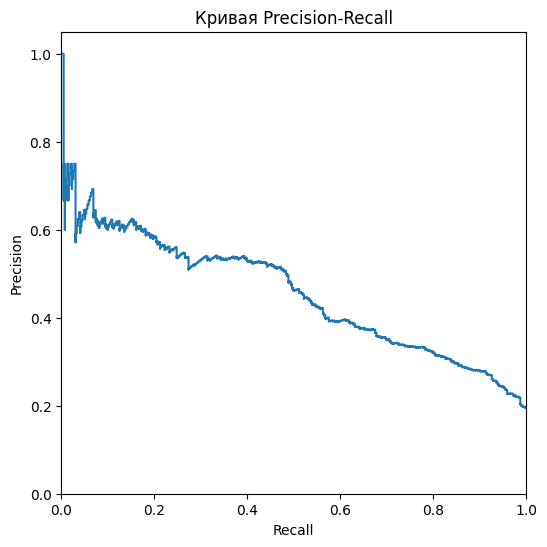

In [75]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')

plt.show()

Для порога 0.30 самый высокий показатель F1 и ROC-AUC

In [76]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('threshold=0.3')

In [77]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,without_imbalance
3,RandomForestClassifier,0.58,0.81,class_weight
4,RandomForestClassifier,0.58,0.84,upsampling
5,CatBoostClassifier,0.57,0.85,downsampled
6,DecisionTreeClassifier,0.56,0.81,class_weight
7,DecisionTreeClassifier,0.56,0.82,upsampling
8,DecisionTreeClassifier,0.55,0.82,without_imbalance
9,DecisionTreeClassifier,0.55,0.81,downsampled


#### Модель Дерево решений 

In [78]:
%%time
1 + 1
model = DecisionTreeClassifier(max_depth=5) # обучим модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучим модель
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold # < напишите код здесь >
    precision = precision_score(target_valid, predicted_valid)# < напишите код здесь >
    recall = recall_score(target_valid, predicted_valid)# < напишите код здесь >
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

Порог = 0.00 | Точность = 0.194, Полнота = 0.992, F1-мера = 0.325
Порог = 0.05 | Точность = 0.248, Полнота = 0.957, F1-мера = 0.393
Порог = 0.10 | Точность = 0.389, Полнота = 0.803, F1-мера = 0.524
Порог = 0.15 | Точность = 0.389, Полнота = 0.803, F1-мера = 0.524
Порог = 0.20 | Точность = 0.434, Полнота = 0.724, F1-мера = 0.543
Порог = 0.25 | Точность = 0.573, Полнота = 0.542, F1-мера = 0.557
Порог = 0.30 | Точность = 0.573, Полнота = 0.542, F1-мера = 0.557
Порог = 0.35 | Точность = 0.573, Полнота = 0.542, F1-мера = 0.557
Порог = 0.40 | Точность = 0.688, Полнота = 0.473, F1-мера = 0.561
Порог = 0.45 | Точность = 0.688, Полнота = 0.473, F1-мера = 0.561
Порог = 0.50 | Точность = 0.701, Полнота = 0.450, F1-мера = 0.548
Порог = 0.55 | Точность = 0.751, Полнота = 0.394, F1-мера = 0.517
Порог = 0.60 | Точность = 0.873, Полнота = 0.263, F1-мера = 0.405
Порог = 0.65 | Точность = 0.873, Полнота = 0.263, F1-мера = 0.405
Порог = 0.70 | Точность = 0.880, Полнота = 0.263, F1-мера = 0.406
Порог = 0.

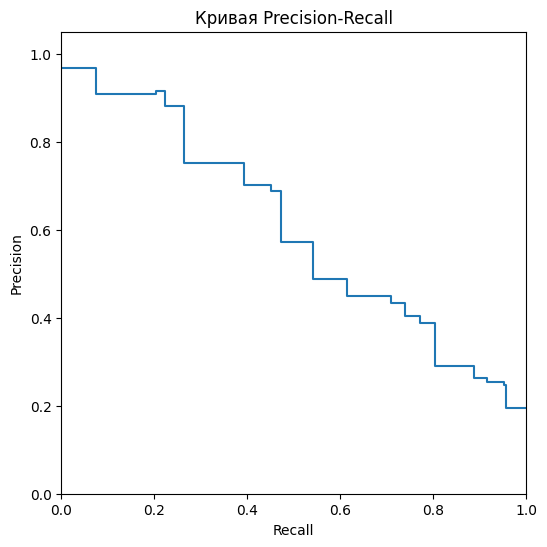

In [79]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Для порога 0.4 самый высокий показатель F1

In [80]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('threshold=0.4')

In [81]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.60,0.86,without_imbalance
1,CatBoostClassifier,0.60,0.74,upsampling
2,RandomForestClassifier,0.58,0.84,upsampling
3,RandomForestClassifier,0.58,0.84,without_imbalance
4,RandomForestClassifier,0.58,0.81,class_weight
5,CatBoostClassifier,0.57,0.85,downsampled
6,DecisionTreeClassifier,0.56,0.82,upsampling
7,DecisionTreeClassifier,0.56,0.82,threshold=0.4
8,DecisionTreeClassifier,0.56,0.81,class_weight
9,DecisionTreeClassifier,0.55,0.82,without_imbalance


#### Модель случайный лес

In [82]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold # < напишите код здесь >
    precision = precision_score(target_valid, predicted_valid)# < напишите код здесь >
    recall = recall_score(target_valid, predicted_valid)# < напишите код здесь >
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

Порог = 0.00 | Точность = 0.198, Полнота = 0.997, F1-мера = 0.331
Порог = 0.05 | Точность = 0.251, Полнота = 0.959, F1-мера = 0.398
Порог = 0.10 | Точность = 0.313, Полнота = 0.908, F1-мера = 0.465
Порог = 0.15 | Точность = 0.360, Полнота = 0.829, F1-мера = 0.502
Порог = 0.20 | Точность = 0.422, Полнота = 0.770, F1-мера = 0.545
Порог = 0.25 | Точность = 0.479, Полнота = 0.698, F1-мера = 0.568
Порог = 0.30 | Точность = 0.543, Полнота = 0.642, F1-мера = 0.589
Порог = 0.35 | Точность = 0.628, Полнота = 0.596, F1-мера = 0.612
Порог = 0.40 | Точность = 0.683, Полнота = 0.540, F1-мера = 0.603
Порог = 0.45 | Точность = 0.706, Полнота = 0.478, F1-мера = 0.570
Порог = 0.50 | Точность = 0.760, Полнота = 0.430, F1-мера = 0.549
Порог = 0.55 | Точность = 0.784, Полнота = 0.389, F1-мера = 0.520
Порог = 0.60 | Точность = 0.822, Полнота = 0.355, F1-мера = 0.496
Порог = 0.65 | Точность = 0.866, Полнота = 0.315, F1-мера = 0.462
Порог = 0.70 | Точность = 0.886, Полнота = 0.279, F1-мера = 0.424
Порог = 0.

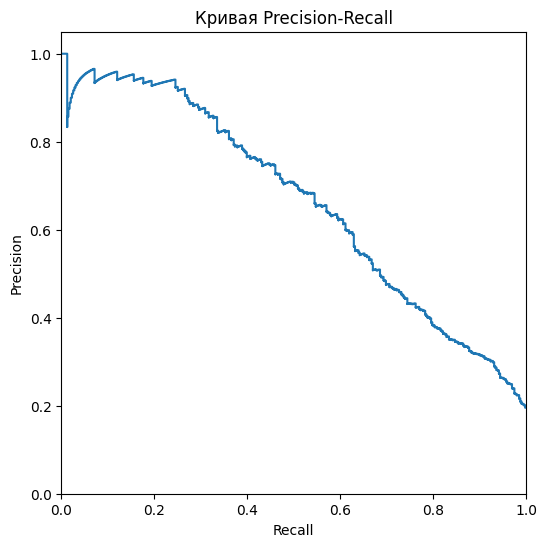

In [83]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Для порога 0.35 самый высокий показатель F1

In [84]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('threshold=0.35')

In [85]:
%%time
1 + 1
model = CatBoostClassifier(verbose=100, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_valid > threshold # < напишите код здесь >
    precision = precision_score(target_valid, predicted_valid)# < напишите код здесь >
    recall = recall_score(target_valid, predicted_valid)# < напишите код здесь >
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

Learning rate set to 0.022141
0:	learn: 0.6754999	total: 2.43ms	remaining: 2.43s
100:	learn: 0.3343972	total: 621ms	remaining: 5.53s
200:	learn: 0.3110064	total: 1.1s	remaining: 4.38s
300:	learn: 0.2963858	total: 1.67s	remaining: 3.87s
400:	learn: 0.2844886	total: 2.25s	remaining: 3.37s
500:	learn: 0.2741070	total: 2.88s	remaining: 2.87s
600:	learn: 0.2646223	total: 3.52s	remaining: 2.34s
700:	learn: 0.2550124	total: 4.06s	remaining: 1.73s
800:	learn: 0.2456157	total: 4.72s	remaining: 1.17s
900:	learn: 0.2361567	total: 5.31s	remaining: 584ms
999:	learn: 0.2277176	total: 6.2s	remaining: 0us
Порог = 0.00 | Точность = 0.196, Полнота = 1.000, F1-мера = 0.327
Порог = 0.05 | Точность = 0.281, Полнота = 0.944, F1-мера = 0.433
Порог = 0.10 | Точность = 0.364, Полнота = 0.877, F1-мера = 0.515
Порог = 0.15 | Точность = 0.433, Полнота = 0.803, F1-мера = 0.562
Порог = 0.20 | Точность = 0.501, Полнота = 0.752, F1-мера = 0.601
Порог = 0.25 | Точность = 0.542, Полнота = 0.696, F1-мера = 0.609
Порог =

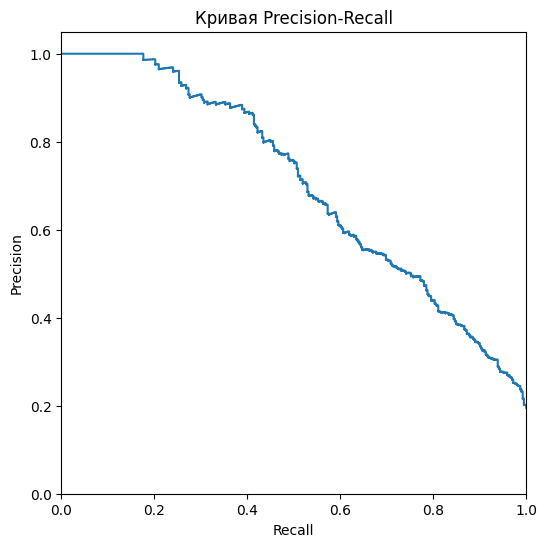

In [86]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

Самый высокий покаатель с порогом 0.25

In [87]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('threshold=0.25')

In [88]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,CatBoostClassifier,0.61,0.86,threshold=0.25
1,RandomForestClassifier,0.61,0.84,threshold=0.35
2,CatBoostClassifier,0.60,0.86,without_imbalance
3,CatBoostClassifier,0.60,0.74,upsampling
4,RandomForestClassifier,0.58,0.81,class_weight
5,RandomForestClassifier,0.58,0.84,upsampling
6,RandomForestClassifier,0.58,0.84,without_imbalance
7,CatBoostClassifier,0.57,0.85,downsampled
8,DecisionTreeClassifier,0.56,0.81,class_weight
9,DecisionTreeClassifier,0.56,0.82,upsampling


#### Сравнение:

Изменение порога квалификации смогло значительно улучшить модели. 

## Вывод

<div class="alert alert-info"> <b>
У нас определились две самые удачные модели - CatBoostClassifier с лучшей F1-мерой и мерой ROC-AUC полученной с параметром threshold=0.25 и RandomForestClassifier с порогом 0.3. Попробуем подобрать для нее оптимальные гиперпараметры.

    1. Кроме того, мы выявили что при наличии дисбаланса для нашей задачи, лучше всего подходит параметр изменение порога для RandomForestClassifier и немного для CatBoostClassifier.
    2. Увеличение выборки показало себя лучше чем ее уменьшение. Но не подходит для CatBoostClassifier и RandomForestClassifier
</div>


## Оптимизация гиперпараметров для модели случайный лес 

### Этап 1. RandomizedSearchCV

Начать можно с алгоритма RandomizedSearchCV, который позволяет довольно грубо исследовать широкие диапазоны значений. Проверять будем на выборке (other), с параметром class_weight = {1:3.5} с применением кроссвалидации. Получим базовую модель, проверять будем по F1-мере.

In [89]:
%%time
1 + 1
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 25)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 25)]
bootstrap = [True, False]
class_weight = [{1:3.5}, {1:3.6}, {1:3.4},]
#В ходе работы мы генерируем сущность param_dist, содержащую, для каждого гиперпараметра, диапазон значений, которые нужно испытать
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}
model = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345,
                        scoring = 'f1')
model.fit(features_other, target_other)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 2.59 s, sys: 121 ms, total: 2.72 s
Wall time: 2min 14s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{1: 3.5}, {1: 3.6},
                                                         {1: 3.4}],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20, 22,
                                                             24, 26, 28, 30, 32,
                                                             34, 36, 38, 40, 42,
                                                             44, 46, 48, 50],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20, 22, 24, 26,
                                                              28, 30, 32, 34,
                                                              36, 38, 40, 42,
                                                              44, 46, 48, 50],
                                        'n_estimators': [2, 6, 10, 14, 18, 22,
                                                         26, 30, 34, 38, 42, 46,
                                                         51, 55, 59, 63, 67, 71,
                                                         75, 79, 83, 87, 91, 95,
                                                         100]},
                   random_state=12345, scoring='f1', verbose=1)

* При значениях параметров n_iter = 100 и cv = 5, мы создали 500 RF-моделей, случайно выбирая комбинации представленных выше гиперпараметров
* Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, мы легко можем получить датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV.

In [90]:
rs_df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,83,36,4,sqrt,15,{1: 3.4},False,0.631884,0.656115,0.616259,1
1,91,34,4,log2,8,{1: 3.4},True,0.618557,0.629310,0.614620,2
2,67,36,2,sqrt,14,{1: 3.4},True,0.616333,0.643713,0.614325,3
3,75,2,8,log2,8,{1: 3.6},True,0.615603,0.637394,0.612177,4
4,51,6,10,sqrt,10,{1: 3.5},False,0.628734,0.640227,0.611186,5
...,...,...,...,...,...,...,...,...,...,...,...
95,91,50,34,sqrt,1,{1: 3.6},True,0.543716,0.552672,0.538481,96
96,38,28,8,log2,2,{1: 3.6},False,0.508301,0.574586,0.534963,97
97,59,40,28,sqrt,1,{1: 3.4},False,0.533333,0.517711,0.511885,98
98,22,28,34,log2,1,{1: 3.5},False,0.524005,0.554364,0.509256,99


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

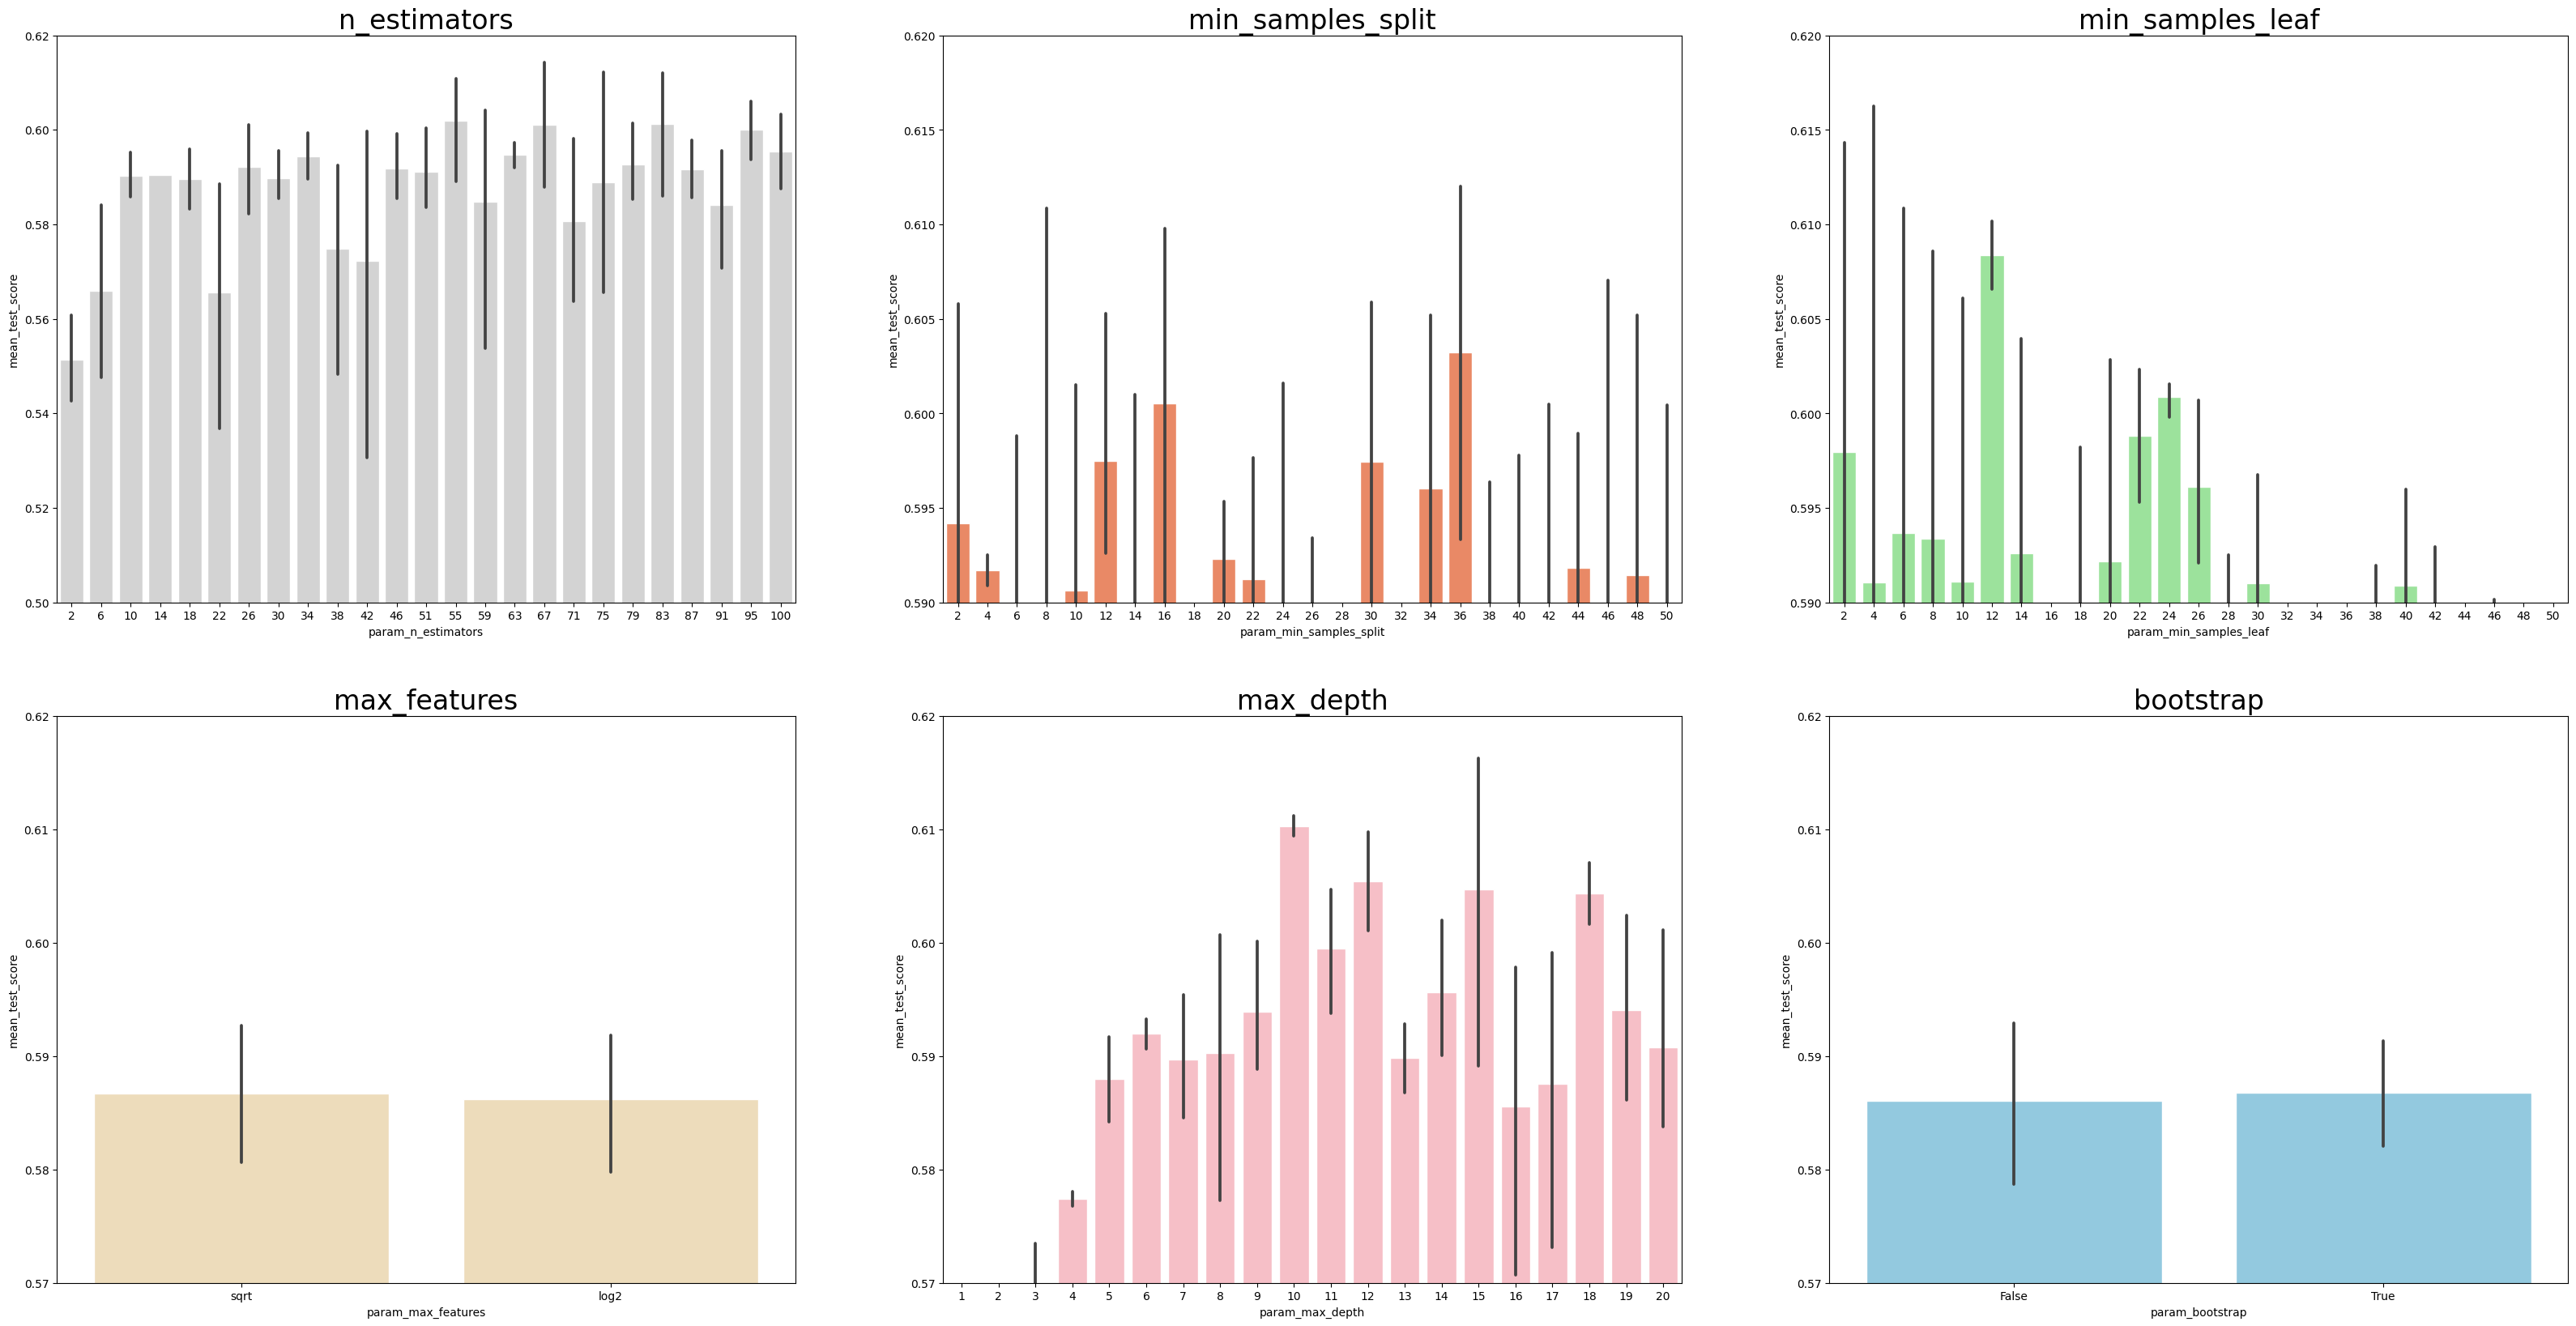

In [91]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(40,20)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.5,.62])
axs[0,0].set_title('n_estimators')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.59,.62])
axs[0,1].set_title('min_samples_split')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.59,.62])
axs[0,2].set_title('min_samples_leaf')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.57,.62])
axs[1,0].set_title('max_features')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.57,.62])
axs[1,1].set_title('max_depth')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.57,.62])
axs[1,2].set_title('bootstrap')

plt.show()

Анализируя графики можно увидеть некоторые закономеренности:
1. n_estimators - выберем лучшие параметры 55, 67, 83
2. min_samples_split - выберем лучшие параметры 12, 16, 36
3. min_samples_leaf - выберем лучшие параметры 4, 8, 12.
4. max_features -  вариант log2 и sqrt
5. max_depth - выберем лучшие параметры 10, 15, 18
6. bootstrap - вариант True и False

### Этап 2. Оптимизация гиперпараметров. GridSearchCV

In [92]:
%%time
1 + 1
n_estimators = [55, 67, 83]
max_features = ['log2', 'sqrt']
max_depth = [10, 15, 18]
min_samples_split = [12, 16, 36]
min_samples_leaf = [4, 8, 12]
bootstrap = [True, False]
class_weight = [{1:3.5}, {1:3.6}, {1:3.4},]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}
model = GridSearchCV(RandomForestClassifier(), 
                     param_dist, 
                     cv = 3, 
                     verbose = 1, 
                     n_jobs=-1)
model.fit(features_other, target_other)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
CPU times: user 8.14 s, sys: 623 ms, total: 8.76 s
Wall time: 14min 43s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [{1: 3.5}, {1: 3.6}, {1: 3.4}],
                         'max_depth': [10, 15, 18],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [4, 8, 12],
                         'min_samples_split': [12, 16, 36],
                         'n_estimators': [55, 67, 83]},
             verbose=1)

Лучшая модель хранится в атрибуте best_estimator_

gsearch.best_estimator_
Оценка лучшей модели, полученная с помощью кросс-валидации хранится в атрибуте best_score_

gsearch.best_score_
Параметры лучшей модели хранятся в атрубите best_params_

gsearch.best_params_
Таким образом, один раз обучив объект GridSearchCV мы сразу получаем и лучшую модель и лучшие гиперпараметры и оценку модели полученную с помощью кросс-валидации. И нет необходимости в дополнительном обучении модели и определении метрик по выделенной валидационной выборке.

In [93]:
model.best_estimator_

RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=83)

In [94]:
model.best_score_

0.8526262611772178

Выше порога 0.59 на валидационной выборке и тестовой. Попробуем на тест выборке и посмотрим как ведет себя модель на незнакомых данных

## Оптимизация гиперпараметров для модели CatBoostClassifier

Попробуем настроить Catboost с применением кроссвалидации. Получим базовую модель, проверять будем по F1-мере. 

In [95]:
model_cat = CatBoostClassifier(custom_loss=['F1'], random_seed=12345, logging_level='Silent')

In [96]:
model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))

Проведем кроссвалидацию с помощию встроенной функции Pool

In [97]:
cv_params = model_cat.get_params()
cv_params.update({'loss_function': 'Logloss'})
cv_data = cv(Pool(features_train, target_train),cv_params)

In [98]:
cv_params

{'random_seed': 12345,
 'logging_level': 'Silent',
 'custom_loss': ['F1'],
 'loss_function': 'Logloss'}

In [99]:
print('F1-мера: {}'.format(np.max(cv_data['test-F1-mean'])))

F1-мера: 0.5978681578885929


In [100]:
probabilities_valid = model_cat.predict_proba(features_valid)[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_valid)

print("AUC:", auc_roc)

AUC: 0.867969334895306


Выше порога 0.59 на валидационной выборке и тестовой. Хорошие показания метрики ROC-AUC Попробуем на тест выборке и посмотрим как ведет себя модель на незнакомых данных

### Вывод 

Подобрали оптимальные гиперпараметры c лучшей F1-мерой для RandomForestClassifier(class_weight='balanced', max_depth=19, min_samples_leaf=2, min_samples_split=10,n_estimators=30, random_state=12345) 

## Тестирование модели

### RandomForestClassifier

In [101]:
model = RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=83,
                       random_state=12345)

model_rfc1 = model.fit(features_train, target_train)
predicted_test = model_rfc1.predict(features_test)
print("F1= {:.3f}\n".format(f1_score(target_test, predicted_test)))

probabilities_test = model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

print("Accuracy = {:.3f}\n".format(accuracy_score(target_test, predicted_test)))

print("Recall = {:.3f}\n".format(recall_score(target_test, predicted_test)))

print("Precision= {:.3f}\n".format(precision_score(target_test, predicted_test)))


F1= 0.636

AUC_ROC = 0.868

Accuracy = 0.851

Recall = 0.611

Precision= 0.662



Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUCZROC (Area Under Curve ROC).
Это новая метрика качества, которая изменяется от 0 до 1. AUCZROC случайной модели равна 0.5.

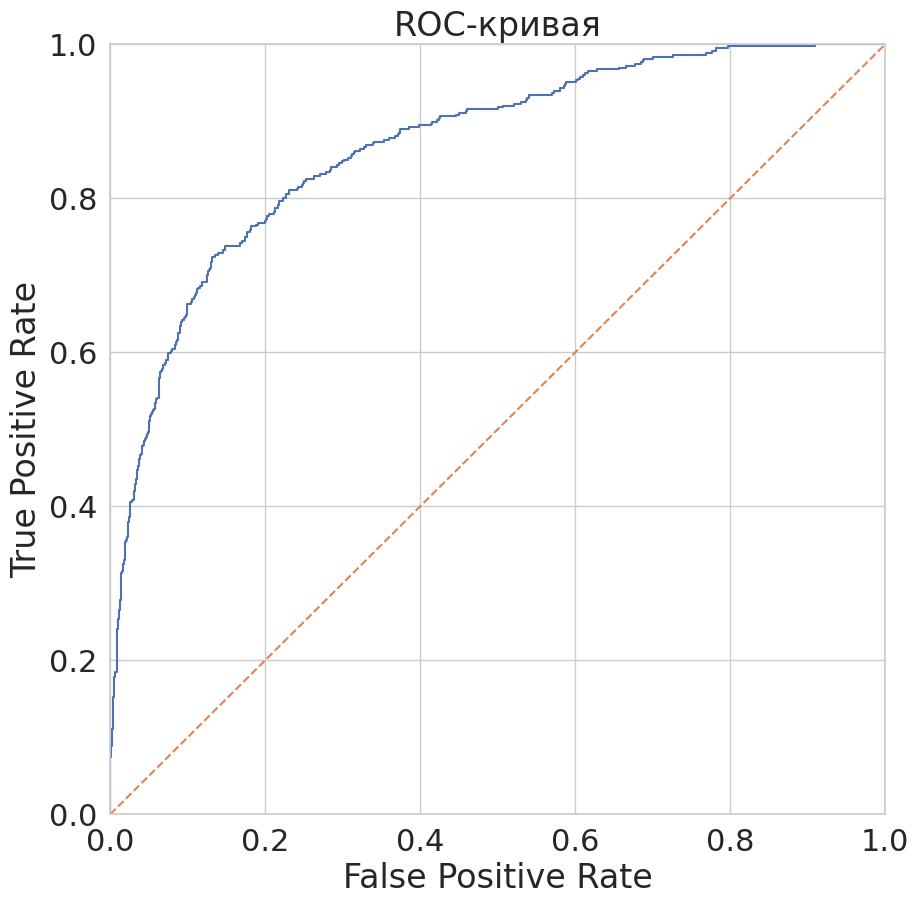

AUC: 0.8682316193493542


In [102]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_test)

print("AUC:", auc_roc)

In [103]:
tabl_prec.append(round(f1_score(target_test, predicted_test), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('test')

### CatBoostClassifier

In [104]:
model_cat = CatBoostClassifier(random_seed=42,logging_level= 'Silent',custom_loss= ['F1'], loss_function= 'Logloss')
model_cat = model_cat.fit(features_train, target_train)
predicted_test = model_cat.predict(features_test)
print("F1= {:.3f}\n".format(f1_score(target_test, predicted_test)))

probabilities_test = model_cat.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_test)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

print("Accuracy = {:.3f}\n".format(accuracy_score(target_test, predicted_test)))

print("Recall = {:.3f}\n".format(recall_score(target_test, predicted_test)))

print("Precision= {:.3f}\n".format(precision_score(target_test, predicted_test)))

F1= 0.591

AUC_ROC = 0.873

Accuracy = 0.860

Recall = 0.473

Precision= 0.786



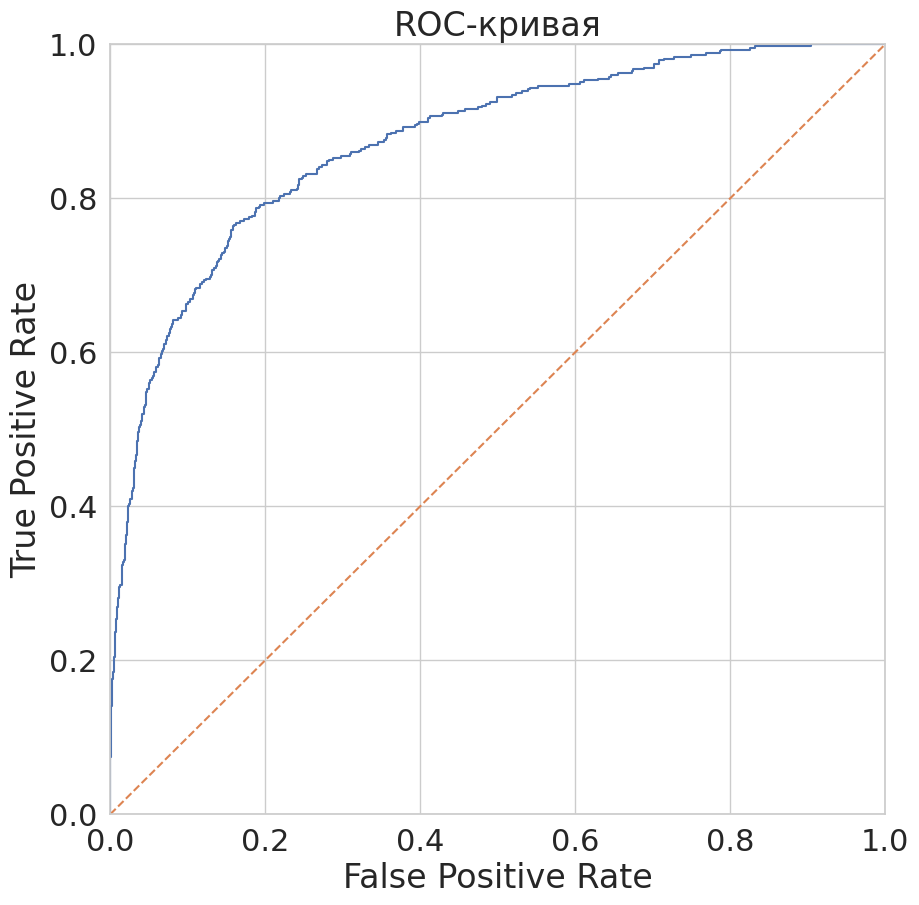

AUC: 0.8729050383297775


In [105]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_test)

print("AUC:", auc_roc)

In [106]:
tabl_prec.append(round(f1_score(target_test, predicted_test), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('test')

In [107]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Notice': tabl_not}).sort_values(by='F1 score', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Notice
0,RandomForestClassifier,0.64,0.87,test
1,RandomForestClassifier,0.61,0.84,threshold=0.35
2,CatBoostClassifier,0.61,0.86,threshold=0.25
3,CatBoostClassifier,0.60,0.74,upsampling
4,CatBoostClassifier,0.60,0.86,without_imbalance
5,CatBoostClassifier,0.59,0.87,test
6,RandomForestClassifier,0.58,0.81,class_weight
7,RandomForestClassifier,0.58,0.84,upsampling
8,RandomForestClassifier,0.58,0.84,without_imbalance
9,CatBoostClassifier,0.57,0.85,downsampled


In [108]:
model_cat.feature_importances_

array([11.41660844,  3.05358441, 18.84085193,  7.43120884, 13.65095016,
       18.49680806,  1.12665484,  6.98735623, 10.81494697,  6.24856825,
        1.93246187])

In [109]:
model_rfc1.feature_importances_

array([0.09894422, 0.02281794, 0.30112186, 0.05756063, 0.13047728,
       0.16040435, 0.01282303, 0.05518014, 0.10138008, 0.04774879,
       0.01154167])

In [110]:
features_test.columns

Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'Germany',
       'Spain'],
      dtype='object')

In [111]:
f1_table = pd.DataFrame({'name':features_test.columns,'f1_table':model_rfc1.feature_importances_,'f2_table':model_cat.feature_importances_})
f1_table.sort_values('f1_table',ascending=False)

,name,f1_table,f2_table
2,age,0.301122,18.840852
5,num_of_products,0.160404,18.496808
4,balance,0.130477,13.650950
8,estimated_salary,0.101380,10.814947
0,credit_score,0.098944,11.416608
3,tenure,0.057561,7.431209
7,is_active_member,0.055180,6.987356
9,Germany,0.047749,6.248568
1,gender,0.022818,3.053584
6,has_cr_card,0.012823,1.126655


# Вывод

Самые важные признаки, на которые стоит обратить внимание банковским маркетологам:

1. возраст клиента
2. количество продуктов банка, используемых клиентом
3. баланс на счёте
4. предполагаемая зарплата
5. кредитный рейтинг

Для прогнозирования оттока, можно использовать модель на основе алгоритма Случайного леса с параметрами RandomForestClassifier(class_weight={1: 3.4}, max_depth=18, min_samples_leaf=4,min_samples_split=12, n_estimators=83) и модель CatBoostClassifier(random_seed=42,logging_level= 'Silent',custom_loss= ['F1'], loss_function= 'Logloss')

